In [1]:
import os
import pandas as pd
from matplotlib import pyplot as plt
import cv2
import numpy as np

#data path 수정
os.chdir("C:\\Users\\Owner2\\Desktop\\G팔로미_vuno")
os.getcwd()

'C:\\Users\\Owner2\\Desktop\\G팔로미_vuno'

In [2]:
X=np.load('data_X.npy')
y=np.load('data_y.npy')

In [3]:
#train, validation set 분리
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.25)

In [4]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    #featurewise_center=True, #center 중심 유지
    #featurewise_std_normalization=True, #normalization
    rotation_range=25.0,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #brightness_range=[0.2,1.0],
    zoom_range=[0.8,1.2],
    horizontal_flip=True) #수평방향 뒤집기

datagen.fit(X_train)

dgf=datagen.flow(X_train,y_train,batch_size=32)

Using TensorFlow backend.


In [5]:
from keras import models, layers
from keras import Input
from keras.applications import VGG16
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, initializers, regularizers, metrics
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import BatchNormalization, Conv2D, Activation, Dense, GlobalAveragePooling2D, MaxPooling2D, ZeroPadding2D, Add

model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model.trainable = False
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [6]:
for layer in model.layers:
    layer.trainable=False

x=model.output
x=layers.Flatten()(x)
outputs=Dense(4, activation='softmax')(x)

additional_model=Model(inputs=model.input, outputs=outputs)

additional_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [7]:
def f1score(precision, recall):
    _f1score = ( 2 * recall * precision) / (recall + precision)
    
    # return a single tensor value
    return _f1score

In [8]:
# checkpoint = ModelCheckpoint(filepath='My_VGG_{epoch:03d}_{val_loss:.7f}.hdf5',monitor='loss', mode='min', save_best_only=True)
checkpoint = ModelCheckpoint(filepath='VGG16_참고문헌_1.hdf5', 
            monitor='loss', 
            mode='min', 
            save_best_only=True)

In [9]:
import tensorflow as tf

additional_model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.Adam(lr=1e-3),
              metrics=['acc',tf.keras.metrics.AUC(),
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),f1score])

In [10]:
history = additional_model.fit_generator(dgf, 
            steps_per_epoch=30, 
            epochs=3, 
            validation_data=(X_val,y_val), 
            validation_steps=32, 
            callbacks=[checkpoint])

Epoch 1/3
30/30 [==============================] - 11s 359ms/step - loss: 1.4798 - acc: 0.3712 - auc: 0.5949 - precision: 0.3489 - recall: 0.2574 - f1score: 0.1141 - val_loss: 1.1169 - val_acc: 0.4247 - val_auc: 0.6775 - val_precision: 0.4020 - val_recall: 0.2832 - val_f1score: 0.1312
Epoch 2/3
30/30 [==============================] - 8s 250ms/step - loss: 1.0284 - acc: 0.5027 - auc: 0.7156 - precision: 0.4412 - recall: 0.2956 - f1score: 0.1406 - val_loss: 1.0476 - val_acc: 0.4619 - val_auc: 0.7403 - val_precision: 0.4713 - val_recall: 0.3096 - val_f1score: 0.1372
Epoch 3/3
30/30 [==============================] - 8s 272ms/step - loss: 1.0314 - acc: 0.5104 - auc: 0.7510 - precision: 0.4866 - recall: 0.3161 - f1score: 0.1413 - val_loss: 1.1154 - val_acc: 0.4495 - val_auc: 0.7596 - val_precision: 0.4964 - val_recall: 0.3273 - val_f1score: 0.1360


In [11]:
for layer in additional_model.layers[:11]:
    layer.trainable=False

for layer in additional_model.layers[11:]:
    layer.trainable=True

In [12]:
for layer in additional_model.layers:
    print(layer, layer.trainable)
    
additional_model.summary()

<keras.engine.input_layer.InputLayer object at 0x0000028851E43088> False
<keras.layers.convolutional.Conv2D object at 0x0000028851E4F0C8> False
<keras.layers.convolutional.Conv2D object at 0x0000028851E4FE48> False
<keras.layers.pooling.MaxPooling2D object at 0x000002888623BBC8> False
<keras.layers.convolutional.Conv2D object at 0x0000028886236188> False
<keras.layers.convolutional.Conv2D object at 0x000002888623FF88> False
<keras.layers.pooling.MaxPooling2D object at 0x00000288862B1448> False
<keras.layers.convolutional.Conv2D object at 0x00000288862B1248> False
<keras.layers.convolutional.Conv2D object at 0x00000288862BD088> False
<keras.layers.convolutional.Conv2D object at 0x00000288862C7548> False
<keras.layers.pooling.MaxPooling2D object at 0x00000288862CD908> False
<keras.layers.convolutional.Conv2D object at 0x00000288862CD8C8> True
<keras.layers.convolutional.Conv2D object at 0x00000288862D7788> True
<keras.layers.convolutional.Conv2D object at 0x00000288862DFC88> True
<keras.

C:\Users\Owner2\Anaconda3\envs\keras2\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [13]:
import tensorflow as tf

additional_model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.Adam(lr=1e-4),
              metrics=['acc',tf.keras.metrics.AUC(),
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),f1score])

In [14]:
history = additional_model.fit_generator(dgf, 
            steps_per_epoch=30, 
            epochs=10, 
            validation_data=(X_val,y_val), 
            validation_steps=32, 
            callbacks=[checkpoint])

Epoch 1/10
30/30 [==============================] - 10s 318ms/step - loss: 1.2292 - acc: 0.4284 - auc_1: 0.7036 - precision_1: 0.5103 - recall_1: 0.2836 - f1score: 0.1285 - val_loss: 1.0670 - val_acc: 0.4515 - val_auc_1: 0.7470 - val_precision_1: 0.5351 - val_recall_1: 0.2554 - val_f1score: 0.1346
Epoch 2/10
30/30 [==============================] - 8s 274ms/step - loss: 0.9663 - acc: 0.5052 - auc_1: 0.7686 - precision_1: 0.5466 - recall_1: 0.2742 - f1score: 0.1453 - val_loss: 0.9434 - val_acc: 0.5113 - val_auc_1: 0.7852 - val_precision_1: 0.5536 - val_recall_1: 0.2999 - val_f1score: 0.1466
Epoch 3/10
30/30 [==============================] - 8s 268ms/step - loss: 0.9138 - acc: 0.5239 - auc_1: 0.7953 - precision_1: 0.5591 - recall_1: 0.3128 - f1score: 0.1506 - val_loss: 1.0185 - val_acc: 0.4742 - val_auc_1: 0.8010 - val_precision_1: 0.5592 - val_recall_1: 0.3322 - val_f1score: 0.1448
Epoch 4/10
30/30 [==============================] - 9s 304ms/step - loss: 0.8649 - acc: 0.5483 - auc_1: 0

In [15]:
for layer in additional_model.layers:
    layer.trainable=True

In [16]:
import tensorflow as tf

additional_model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.Adam(lr=1e-5),
              metrics=['acc',tf.keras.metrics.AUC(name='auc'),
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),f1score])

history = additional_model.fit_generator(dgf, 
            steps_per_epoch=30, 
            epochs=37, 
            validation_data=(X_val,y_val), 
            validation_steps=32, 
            callbacks=[checkpoint])

Epoch 1/37
30/30 [==============================] - 10s 328ms/step - loss: 0.7153 - acc: 0.6333 - auc: 0.8835 - precision_2: 0.6463 - recall_2: 0.5554 - f1score: 0.1688 - val_loss: 0.8539 - val_acc: 0.5443 - val_auc: 0.8840 - val_precision_2: 0.6316 - val_recall_2: 0.5512 - val_f1score: 0.1599
Epoch 2/37
30/30 [==============================] - 9s 296ms/step - loss: 0.7246 - acc: 0.6161 - auc: 0.8790 - precision_2: 0.6185 - recall_2: 0.5441 - f1score: 0.1691 - val_loss: 0.7867 - val_acc: 0.5505 - val_auc: 0.8797 - val_precision_2: 0.6224 - val_recall_2: 0.5491 - val_f1score: 0.1621
Epoch 3/37
30/30 [==============================] - 8s 274ms/step - loss: 0.6939 - acc: 0.6416 - auc: 0.8810 - precision_2: 0.6252 - recall_2: 0.5493 - f1score: 0.1716 - val_loss: 0.8929 - val_acc: 0.5361 - val_auc: 0.8811 - val_precision_2: 0.6270 - val_recall_2: 0.5520 - val_f1score: 0.1585
Epoch 4/37
30/30 [==============================] - 9s 312ms/step - loss: 0.6928 - acc: 0.6406 - auc: 0.8809 - precis

Epoch 29/37
30/30 [==============================] - 8s 266ms/step - loss: 0.5254 - acc: 0.7476 - auc: 0.8970 - precision_2: 0.6574 - recall_2: 0.6102 - f1score: 0.1903 - val_loss: 1.0089 - val_acc: 0.5155 - val_auc: 0.8972 - val_precision_2: 0.6577 - val_recall_2: 0.6108 - val_f1score: 0.1543
Epoch 30/37
30/30 [==============================] - 9s 301ms/step - loss: 0.4985 - acc: 0.7582 - auc: 0.8975 - precision_2: 0.6585 - recall_2: 0.6120 - f1score: 0.1925 - val_loss: 0.9598 - val_acc: 0.5278 - val_auc: 0.8977 - val_precision_2: 0.6588 - val_recall_2: 0.6127 - val_f1score: 0.1577
Epoch 31/37
30/30 [==============================] - 8s 273ms/step - loss: 0.5005 - acc: 0.7677 - auc: 0.8980 - precision_2: 0.6594 - recall_2: 0.6136 - f1score: 0.1927 - val_loss: 0.9396 - val_acc: 0.5361 - val_auc: 0.8983 - val_precision_2: 0.6602 - val_recall_2: 0.6148 - val_f1score: 0.1577
Epoch 32/37
30/30 [==============================] - 8s 271ms/step - loss: 0.5116 - acc: 0.7529 - auc: 0.8986 - pre

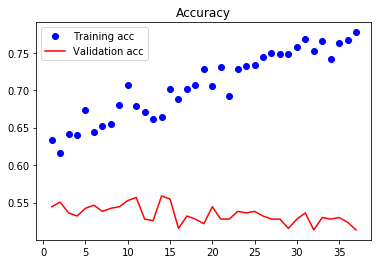

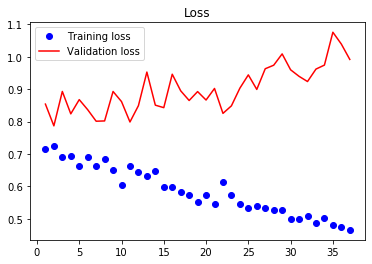

In [17]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(1, len(acc) + 1)
 
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Accuracy')
plt.legend()
plt.figure()
 
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Loss')
plt.legend()
 
plt.show()

In [18]:
X_test=np.load('X_test.npy')
y_test=np.load('y_test.npy')

In [19]:
_loss, _acc, _auc, _precision, _recall, _f1score = additional_model.evaluate(X_val, y_val, batch_size=32)
print('loss: {:.3f}, accuracy: {:.3f}, auc: {:.3f}, precision: {:.3f}, recall: {:.3f}, f1score: {:.3f}'.format(_loss, _acc, _auc, _precision, _recall, _f1score))

485/485 [==============================] - 1s 3ms/step
loss: 0.992, accuracy: 0.513, auc: 0.900, precision: 0.664, recall: 0.622, f1score: 0.155


In [20]:
_loss, _acc, _auc, _precision, _recall, _f1score = additional_model.evaluate(X_test, y_test, batch_size=32)
print('loss: {:.3f}, accuracy: {:.3f}, auc: {:.3f}, precision: {:.3f}, recall: {:.3f}, f1score: {:.3f}'.format(_loss, _acc, _auc, _precision, _recall, _f1score))

704/704 [==============================] - 2s 3ms/step
loss: 70487.620, accuracy: 0.241, auc: 0.896, precision: 0.660, recall: 0.620, f1score: nan


In [21]:
additional_model.save('VGG16_참고문헌_1.h5')

In [22]:
from sklearn.metrics import roc_auc_score

y_pred = additional_model.predict(X_val)
roc_auc_score(y_val, y_pred)

0.8332240254180678